In [1]:
import torch 
import pandas as pd
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

In [2]:
batch_size = 64
n_epochs = 5
n_inputs = 784
n_classes = 10
lr = 0.001
in_channels = 1

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_dataset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)

In [5]:
classes_dict = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [7]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [8]:
test_dataset.data.shape, test_dataset.targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

<ipython-input-9-bb84213b6d23>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 16/2, item+1, xticks=[], yticks=[])


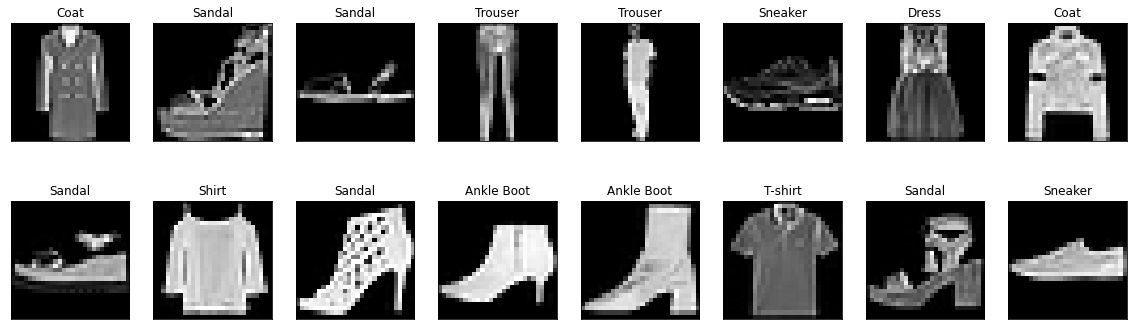

In [9]:
fig = plt.figure(figsize=(20,6)) 
for data, targets in train_loader:
    for item in range(16):
        ax = fig.add_subplot(2, 16/2, item+1, xticks=[], yticks=[])
        ax.imshow(data[item].squeeze(0), cmap='gray')
        ax.set_title(classes_dict[targets[item].item()])
    break

In [26]:
class CNN(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(16*7*7, 256)
        self.fc2 = nn.Linear(256, n_classes)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = self.pool(out)
        out = out.reshape(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = CNN(in_channels=in_channels, n_classes=n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
def train(model, loader, criterion, optimizer):
    best_loss = np.inf
    for epoch in range(n_epochs):
        size = len(loader.dataset)
        for batch_idx, (data, targets) in enumerate(loader):
            optimizer.zero_grad()


            outputs = model(data)
            loss = criterion(outputs, targets)
            
            if loss < best_loss:
                torch.save(model.state_dict(), "model.pth")
                best_loss = loss

            loss.backward()
            optimizer.step()
            
            if batch_idx % 1000 == 0:
                loss, current = loss.item(), batch_idx * len(data)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print('Finished Training')

In [30]:
train(model, train_loader, criterion, optimizer)

loss: 2.307521  [    0/60000]
loss: 0.358514  [    0/60000]
loss: 0.279839  [    0/60000]
loss: 0.220732  [    0/60000]
loss: 0.223454  [    0/60000]
Finished Training


In [31]:
model = CNN(in_channels=in_channels, n_classes=n_classes)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [32]:
def get_accuracy(mode, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:

            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [33]:
get_accuracy(model, test_loader)

Accuracy of the network on the 10000 test images: 88 %


In [34]:
get_accuracy(model, train_loader)

Accuracy of the network on the 10000 test images: 91 %
